<a href="https://colab.research.google.com/github/Bhandari007/Pnemonia_Classification/blob/main/XRAY_IMAGE_CLASSIFICATION.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# `Problem Statement`
> Given a dataset of chest X-ray images, the task is to classify whether a patient has penumonia or not. The desired outcome is to develop a model that can assist in the diagnosis of pneumonia. The model should have a `high recall` to minimize the false negatives and a `high specificity` to minimize the false positives.




# `Choice of Models`
> Based on the journal, https://journals.plos.org/plosone/article?id=10.1371/journal.pone.0256630, I will be using **ResNet** and **DenseNet**, to train on the given dataset.


# `Mount Drive`

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
# Downloading helper functions
!wget https://raw.githubusercontent.com/Bhandari007/Pnemonia_Classification/main/helper_functions.py

--2023-05-06 11:12:29--  https://raw.githubusercontent.com/Bhandari007/Pnemonia_Classification/main/helper_functions.py
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.108.133, 185.199.109.133, 185.199.110.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.108.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 11355 (11K) [text/plain]
Saving to: ‘helper_functions.py’

helper_functions.py 100%[===================>]  11.09K  --.-KB/s    in 0s      

2023-05-06 11:12:29 (75.2 MB/s) - ‘helper_functions.py’ saved [11355/11355]



# Importing necessary libraries

In [ ]:
import os
import matplotlib.pyplot as plt
import random

import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.layers.experimental import preprocessing
from sklearn.metrics import confusion_matrix, classification_report, roc_curve

In [ ]:
from helper_functions import create_tensorboard_callback, plot_loss_curves, unzip_data, walk_through_dir, make_confusion_matrix, evaluate_model, plot_roc_curves

In [ ]:
ROOT_DIR = "drive/MyDrive/NAMMI_ASSIGNMENT/archive.zip"
TRAIN_DIR = "chest_xray/train"
TEST_DIR = "chest_xray/test"
VAL_DIR = "chest_xray/val"

In [ ]:
unzip_data(ROOT_DIR)

# `EXPLORING THE DATA`

## Number of images 

In [ ]:
print("\t\t TRAIN")
walk_through_dir(TRAIN_DIR)
print("\t\t VAL")
walk_through_dir(VAL_DIR)
print("\t\t TEST")
walk_through_dir(TEST_DIR)

		 TRAIN
There are 2 directories and 0 images in 'chest_xray/train'.
There are 0 directories and 3875 images in 'chest_xray/train/PNEUMONIA'.
There are 0 directories and 1341 images in 'chest_xray/train/NORMAL'.
		 VAL
There are 2 directories and 0 images in 'chest_xray/val'.
There are 0 directories and 8 images in 'chest_xray/val/PNEUMONIA'.
There are 0 directories and 8 images in 'chest_xray/val/NORMAL'.
		 TEST
There are 2 directories and 0 images in 'chest_xray/test'.
There are 0 directories and 390 images in 'chest_xray/test/PNEUMONIA'.
There are 0 directories and 234 images in 'chest_xray/test/NORMAL'.


**Insight: Here we can see that we have 3875 X-Ray images belonging to `PNEUMONIA` and 1341 total X-Ray images which are `NORMAL`. So, our model will assumed to have more ability to correctly classify the X-RAY images of `PNEUMONIA`**.

## EXAMPLE IMAGES

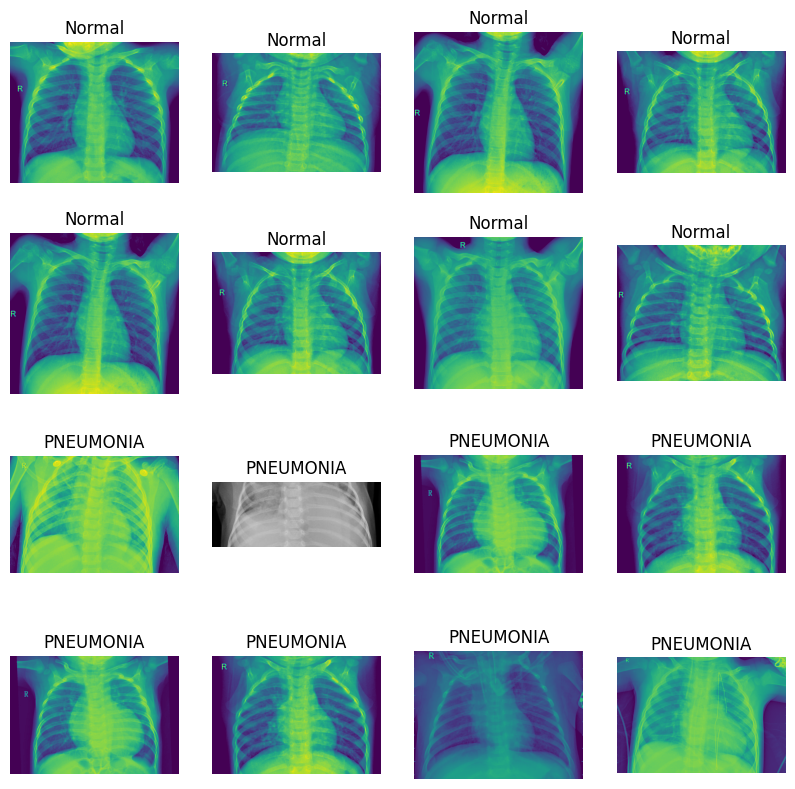

In [ ]:
# Get a list of all the normal and abnormal image filenames
normal_images = os.listdir(os.path.join(TRAIN_DIR, "NORMAL"))
abnormal_images = os.listdir(os.path.join(TRAIN_DIR, "PNEUMONIA"))

# Choose 8 normal and 8 abnormal images randomly
random_normal_images = random.sample(normal_images, 8)
random_abnormal_images = random.sample(abnormal_images, 8)

# Create a 4x4 grid of subplots
fig, ax = plt.subplots(nrows=4, ncols=4, figsize=(10, 10))

# Loop through the subplots and plot the images
for i in range(4):
  for j in range(4):
    if i < 2:
      # Plot the normal images in the top row
      img = plt.imread(os.path.join(TRAIN_DIR, "NORMAL", random_normal_images[i*2+j]))
      ax[i, j].imshow(img)
      ax[i, j].set_title("Normal")
    else:
      # Plot the abnormal images in the bottom row
      img = plt.imread(os.path.join(TRAIN_DIR, "PNEUMONIA", random_abnormal_images[(i-2)*2+j]))
      ax[i, j].imshow(img)
      ax[i, j].set_title("PNEUMONIA")

    ax[i, j].axis("off")

# Display the grid of images
plt.show()

# `Creating Data Loaders`

In [ ]:
IMG_SHAPE = (224, 224)

In [ ]:
train_data = tf.keras.preprocessing.image_dataset_from_directory(TRAIN_DIR,
                                               image_size = IMG_SHAPE,
                                               label_mode='binary')

test_data = tf.keras.preprocessing.image_dataset_from_directory(TEST_DIR,
                                               image_size = IMG_SHAPE,
                                               shuffle=False,
                                               label_mode='binary')

val_data = tf.keras.preprocessing.image_dataset_from_directory(VAL_DIR,
                                               image_size = IMG_SHAPE,
                                               shuffle=False,
                                               label_mode='binary')

Found 5216 files belonging to 2 classes.
Found 624 files belonging to 2 classes.
Found 16 files belonging to 2 classes.


In [ ]:
# class names
train_data.class_names

['NORMAL', 'PNEUMONIA']

# `Experiment Phase I`
The steps that I will be following the upcoming section can be outlined as:

* Create a ResNet model.
* Compile our model
* Feature extraction
* Evaluate
* Perform same for DenseNet Model

# `Model 0: ResNet`
We will create a ResNet model to extract pretrained features for our problem in hand.

In [ ]:
resnet_base_model = tf.keras.applications.resnet50.ResNet50(include_top=False)
resnet_base_model.trainable = False

inputs = layers.Input(shape=(224,224,3),name="input_layer")
x = layers.Rescaling(1./255)(inputs)
x = resnet_base_model(inputs, training=False)
x = layers.GlobalAveragePooling2D(name="global_average_pooling_layer")(x)
outputs = layers.Dense(1, activation = 'sigmoid', name='output_layer')(x)
model = tf.keras.Model(inputs, outputs)

94765736/94765736 [==============================] - 0s 0us/step


In [ ]:
# Compile 

model.compile(loss="binary_crossentropy",
              optimizer = tf.keras.optimizers.Adam(),
              metrics=["accuracy"])

# Fit
resnet_base_model_history = model.fit(train_data,
                          epochs = 5,
                          validation_data = val_data,
                          callbacks=[create_tensorboard_callback("naami", "resnet_base_model")])

Saving TensorBoard log files to: naami/resnet_base_model/20230506-111447
Epoch 1/5
163/163 [==============================] - 51s 228ms/step - loss: 0.2120 - accuracy: 0.9091 - val_loss: 0.5709 - val_accuracy: 0.6875
Epoch 2/5
163/163 [==============================] - 35s 203ms/step - loss: 0.1019 - accuracy: 0.9613 - val_loss: 0.4655 - val_accuracy: 0.7500
Epoch 3/5
163/163 [==============================] - 34s 198ms/step - loss: 0.0822 - accuracy: 0.9705 - val_loss: 0.4878 - val_accuracy: 0.6250
Epoch 4/5
163/163 [==============================] - 35s 205ms/step - loss: 0.0738 - accuracy: 0.9735 - val_loss: 0.5161 - val_accuracy: 0.6250
Epoch 5/5
163/163 [==============================] - 34s 200ms/step - loss: 0.0640 - accuracy: 0.9755 - val_loss: 0.5240 - val_accuracy: 0.6250


In [ ]:
model.evaluate(test_data)

20/20 [==============================] - 3s 140ms/step - loss: 0.6455 - accuracy: 0.7740


[0.6454889178276062, 0.7740384340286255]

## Loss Curves

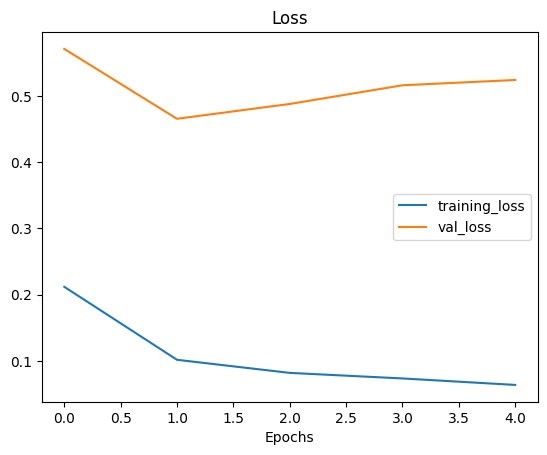

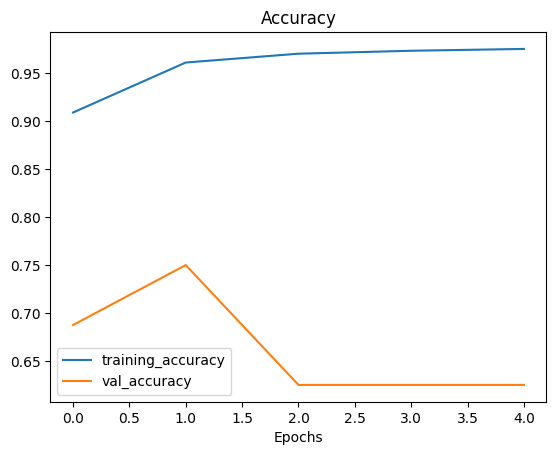

In [ ]:
plot_loss_curves(resnet_base_model_history)

## `Findings`:

Based on the training and validation results, it seems like the model is performing well, achieveing an accuracy of over 97% on the training set and over 62% on the validation set. However, the accuracy on the test set is lower, at round 78%.

This indicates that the model is `overfitting` to the training data and not generalizing well to new data. The possible solutions could be `increasing the size of the dataset`, adjusting the learning rate, adding regulariztion techniques like dropout or weight decay.

To properly evaluate the performance of the model, we will now use `precision, recall and F1 Score` to get a more complete picture of how well the model is performing.

## Evaluation Metrics

In [ ]:
true_labels = []
for batch_images, batch_labels in test_data.unbatch():
    true_labels.append(batch_labels.numpy())

In [ ]:
predictions = model.predict(test_data)

20/20 [==============================] - 5s 151ms/step


### `Classification Report`

In [ ]:
def evaluate_model(true_labels, predictions, class_names, threshold=0.5):
    """
    Makes a confusion matrix for the model
    
    Args:
      true_labels: true label in the form of 1D
      predictions: predicted labels in the form of 1D
      class_names: the class_names in the form of list
    """  
  
    predicted_labels = [0 if prediction < threshold else 1 for prediction in predictions]
    make_confusion_matrix(true_labels, predicted_labels, classes = class_names)
    cm = confusion_matrix(true_labels,predicted_labels)

    print(classification_report(true_labels, predicted_labels))

              precision    recall  f1-score   support

         0.0       1.00      0.40      0.57       234
         1.0       0.73      1.00      0.85       390

    accuracy                           0.77       624
   macro avg       0.87      0.70      0.71       624
weighted avg       0.83      0.77      0.74       624



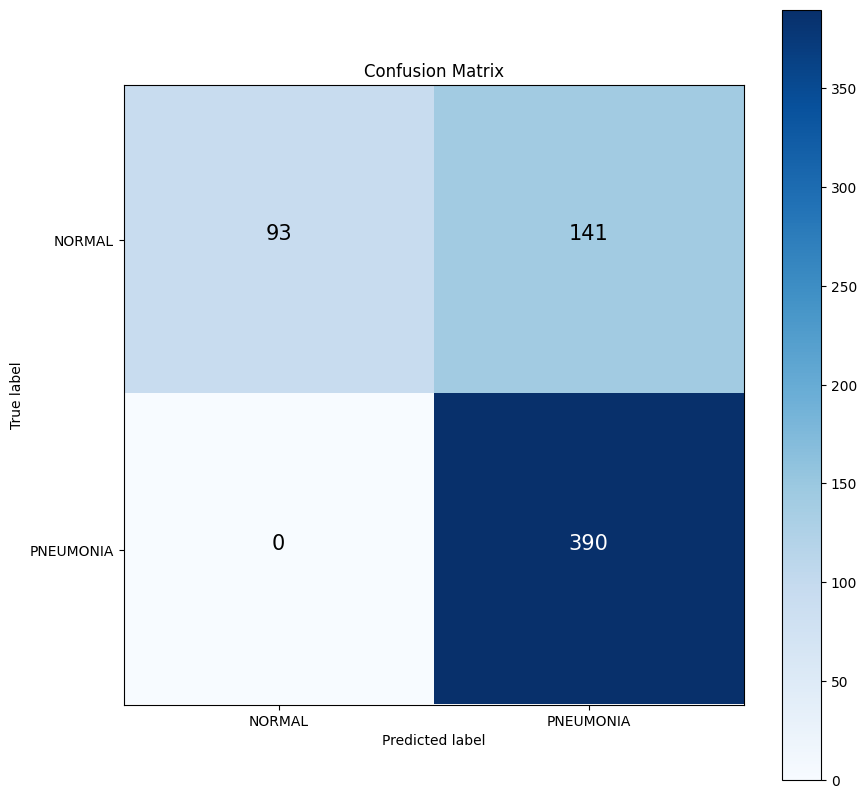

In [ ]:
# Default threshold of 0.5
evaluate_model(true_labels, predictions, test_data.class_names)

### `ROC Curves`

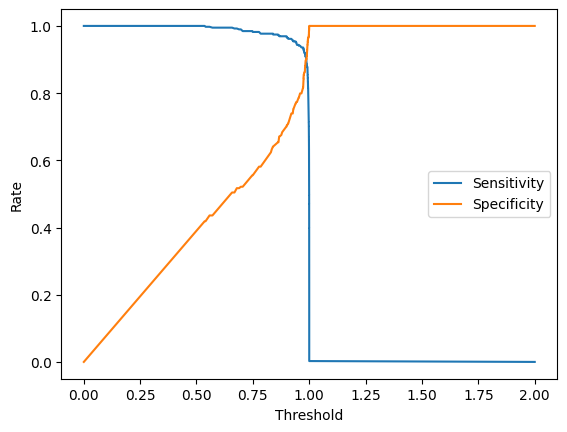

In [ ]:
plot_roc_curves(true_labels, predictions)

              precision    recall  f1-score   support

         0.0       0.94      0.65      0.77       234
         1.0       0.82      0.97      0.89       390

    accuracy                           0.85       624
   macro avg       0.88      0.81      0.83       624
weighted avg       0.87      0.85      0.85       624



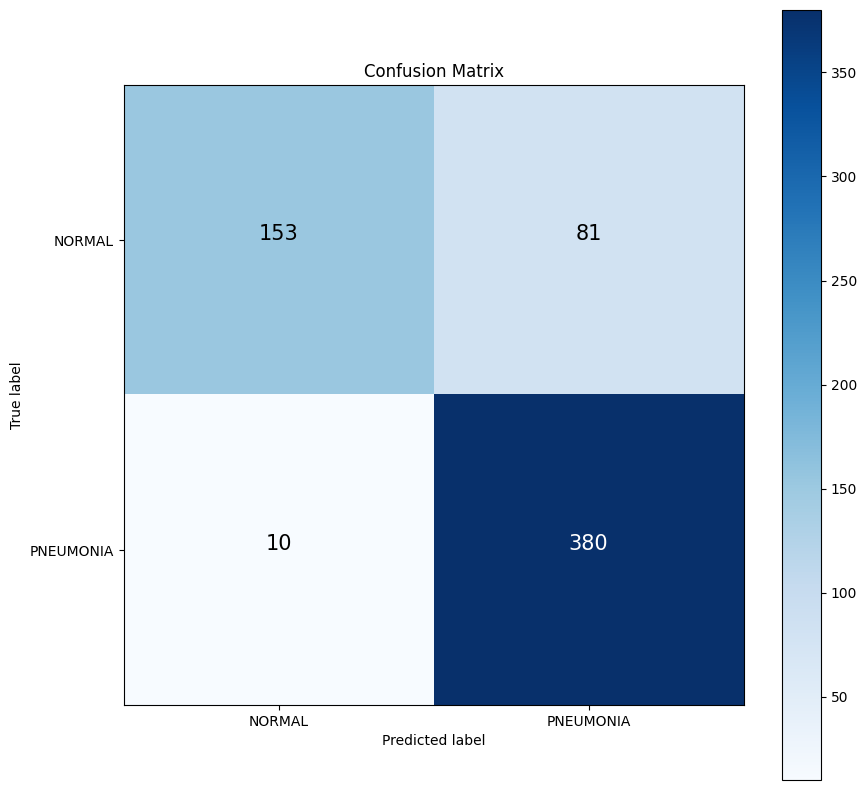

In [ ]:
evaluate_model(true_labels, predictions, test_data.class_names, threshold=0.85)

## `Conclusion`

* The model have high sensitity (TPR);This means that the model is good at identifying positive cases of penumonia but also is classifiying some false positives (i.e normal cases that are incorrectly classified as pneumonia).
In this particular case, the model is incorrecly classified `2 X-Ray images as normal instead of pneumoina.`

* We can strike a balance between `specificity and sensitivity` if we change the threshold from `0.5 to 0.85`

# `Model 1: DenseNet`
We will create a DenseNet model to extract pretrained features for our problem in hand.

In [ ]:
dense_net_base_model = tf.keras.applications.densenet.DenseNet121(include_top=False)
dense_net_base_model.trainable = False

inputs = layers.Input(shape=(224,224,3),name="input_layer")
x = layers.Rescaling(1./255)(inputs)
x = dense_net_base_model(inputs, training=False)
x = layers.GlobalAveragePooling2D(name="global_average_pooling_layer")(x)
outputs = layers.Dense(1, activation = 'sigmoid', name='output_layer')(x)
model_1 = tf.keras.Model(inputs, outputs)

29084464/29084464 [==============================] - 1s 0us/step


In [ ]:
# Compile 

model_1.compile(loss="binary_crossentropy",
              optimizer = tf.keras.optimizers.Adam(),
              metrics=["accuracy"])

# Fit
dense_net_base_model_history = model_1.fit(train_data,
                          epochs = 5,
                          validation_data = val_data,
                          callbacks=[create_tensorboard_callback("naami", "dense_net_base_model")])

Saving TensorBoard log files to: naami/dense_net_base_model/20230506-112507
Epoch 1/5
163/163 [==============================] - 61s 296ms/step - loss: 0.3743 - accuracy: 0.8271 - val_loss: 1.1812 - val_accuracy: 0.5625
Epoch 2/5
163/163 [==============================] - 35s 201ms/step - loss: 0.1886 - accuracy: 0.9293 - val_loss: 1.3565 - val_accuracy: 0.5625
Epoch 3/5
163/163 [==============================] - 34s 202ms/step - loss: 0.1516 - accuracy: 0.9473 - val_loss: 1.5720 - val_accuracy: 0.5625
Epoch 4/5
163/163 [==============================] - 37s 220ms/step - loss: 0.1328 - accuracy: 0.9479 - val_loss: 1.0480 - val_accuracy: 0.6250
Epoch 5/5
163/163 [==============================] - 33s 197ms/step - loss: 0.1218 - accuracy: 0.9567 - val_loss: 1.0346 - val_accuracy: 0.6250


## `Loss Curves`:

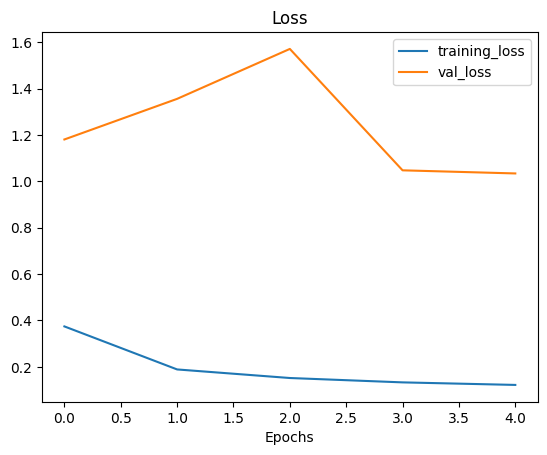

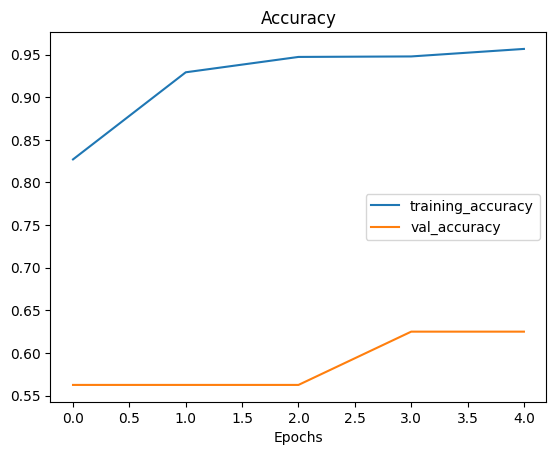

In [ ]:
plot_loss_curves(dense_net_base_model_history)

In [ ]:
model_1.evaluate(test_data)

20/20 [==============================] - 3s 134ms/step - loss: 0.5169 - accuracy: 0.8125


[0.5169188380241394, 0.8125]

## `Findings`:

Based on the training and validation results, it seems like the model is performing well, achieveing an accuracy of over 97% on the training set and over 75% on the validation set. However, the accuracy on the test set is lower, at round 81%. This model also seems to suffer from `overfitting`.

The DenseNet seems to a little more effective than ResNet architectire.

To properly evaluate the performance of the model, I will now use `precision, recall and F1 Score` to get a more complete picture of how well the model is performing.

In [ ]:
predictions = model_1.predict(test_data)

20/20 [==============================] - 7s 232ms/step


### `Classification Report`

              precision    recall  f1-score   support

         0.0       0.97      0.52      0.67       234
         1.0       0.77      0.99      0.87       390

    accuracy                           0.81       624
   macro avg       0.87      0.75      0.77       624
weighted avg       0.85      0.81      0.80       624



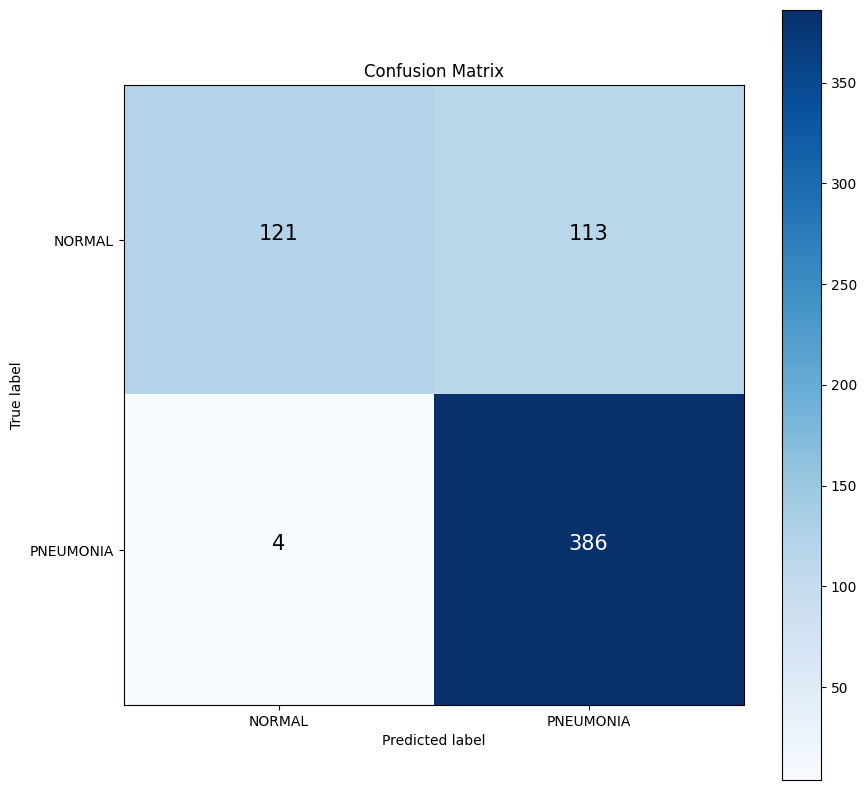

In [ ]:
# Default threshold of 0.5
evaluate_model(true_labels, predictions, test_data.class_names)

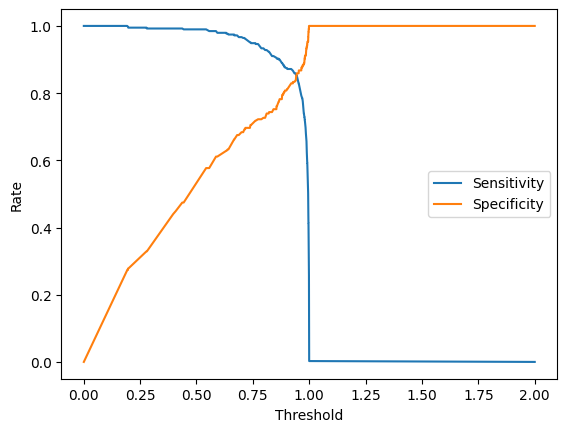

In [ ]:
plot_roc_curves(true_labels, predictions)

              precision    recall  f1-score   support

         0.0       0.83      0.75      0.79       234
         1.0       0.86      0.91      0.88       390

    accuracy                           0.85       624
   macro avg       0.84      0.83      0.83       624
weighted avg       0.85      0.85      0.85       624



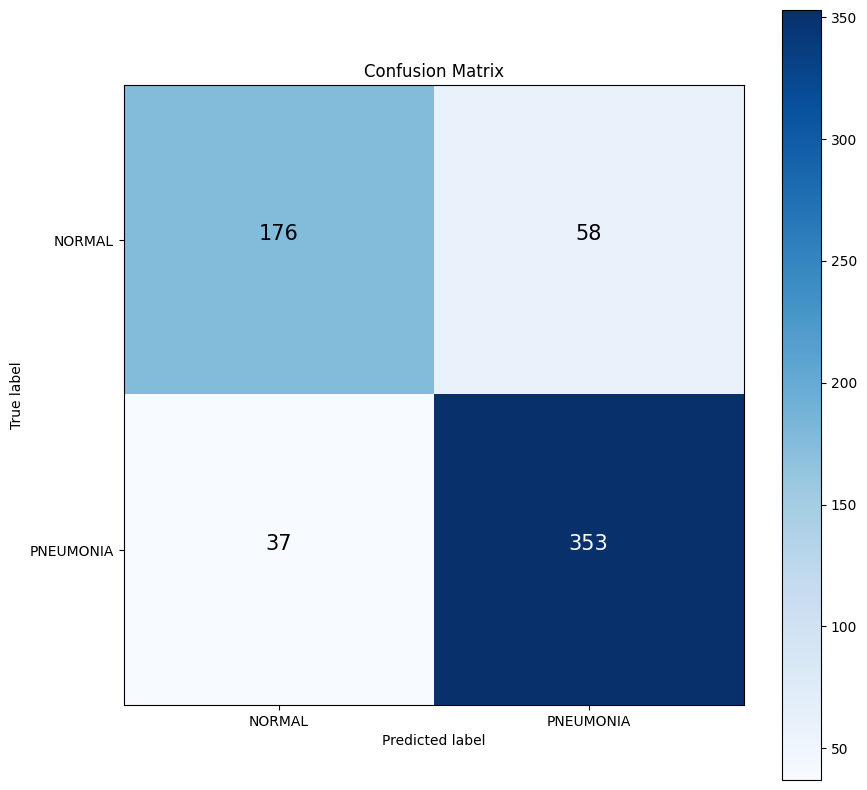

In [ ]:
evaluate_model(true_labels, predictions, test_data.class_names, threshold=0.85)

## `Conclusion`

* The model have high  sensitivity (TPR) but very low specificity (TNR). This means that the model is perfect at identifying positive cases of penumonia but is  bad at classifiying  false positives (i.e normal cases that are incorrectly classified as pneumonia). However, this model seems to perform better then ResNet architecture.

* We can strike the balance between `sensitivity` and `specificity` by changing the threshold from 0.5 to 0.85

# Experimentation Phase II:

After the results shown by ResNet and DenseNet. It is clear that both the models so far are suffering from overfitting problem. To tackle this issue, we will now perform data augmentation and train on both these models.

# `Data Augmentation Layer` 

In [ ]:
data_augmentation = keras.Sequential([
    preprocessing.RandomFlip("horizontal"),
    preprocessing.RandomRotation(0.2),
    preprocessing.RandomZoom(0.2),
    preprocessing.RandomHeight(0.2),
    preprocessing.RandomWidth(0.2),
    preprocessing.Rescaling(1./255)
], name='data_augmentation')

# `Model 0.1: ResNet with Data Augmentation`

In [ ]:
resnet_base_model = tf.keras.applications.resnet50.ResNet50(weights='imagenet',include_top=False)
resnet_base_model.trainable = False

inputs = layers.Input(shape=(224,224,3),name="input_layer")
x = data_augmentation(inputs)
x = resnet_base_model(inputs, training=False)
x = layers.GlobalAveragePooling2D(name="global_average_pooling_layer")(x)
outputs = layers.Dense(1, activation = 'sigmoid', name='output_layer')(x)
model_0_1 = tf.keras.Model(inputs, outputs)

In [ ]:
# Compile 

model_0_1.compile(loss="binary_crossentropy",
              optimizer = tf.keras.optimizers.Adam(),
              metrics=["accuracy"])

# Fit
resnet_base_model_history = model_0_1.fit(train_data,
                          epochs = 5,
                          validation_data = val_data,
                          callbacks=[create_tensorboard_callback("naami", "resnet_data_aug")])

Saving TensorBoard log files to: naami/resnet_data_aug/20230506-113131
Epoch 1/5
163/163 [==============================] - 40s 211ms/step - loss: 0.1684 - accuracy: 0.9342 - val_loss: 0.2989 - val_accuracy: 0.8125
Epoch 2/5
163/163 [==============================] - 36s 214ms/step - loss: 0.0957 - accuracy: 0.9628 - val_loss: 0.5014 - val_accuracy: 0.7500
Epoch 3/5
163/163 [==============================] - 35s 204ms/step - loss: 0.0783 - accuracy: 0.9695 - val_loss: 0.2732 - val_accuracy: 0.8750
Epoch 4/5
163/163 [==============================] - 34s 200ms/step - loss: 0.0658 - accuracy: 0.9762 - val_loss: 0.2754 - val_accuracy: 0.9375
Epoch 5/5
163/163 [==============================] - 33s 195ms/step - loss: 0.0598 - accuracy: 0.9781 - val_loss: 0.3239 - val_accuracy: 0.8750


In [ ]:
model_0_1.evaluate(test_data)

20/20 [==============================] - 3s 126ms/step - loss: 0.5240 - accuracy: 0.8125


[0.5239975452423096, 0.8125]

### `Loss Curves`

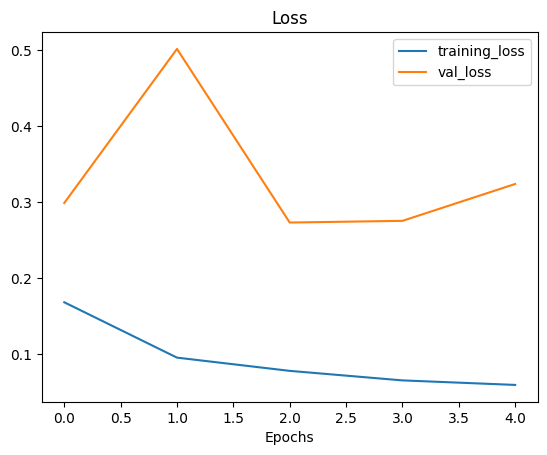

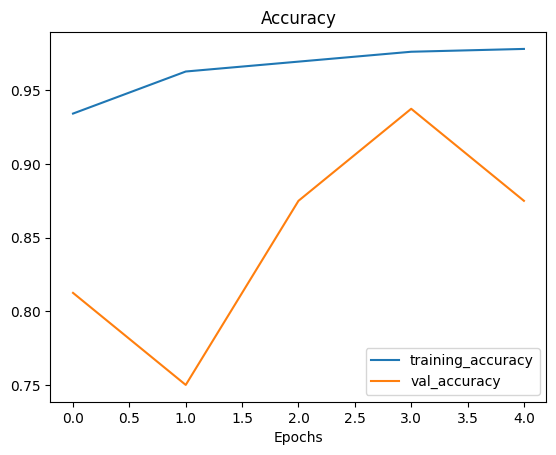

In [ ]:
plot_loss_curves(resnet_base_model_history)

## `Findings`:
After applying data augmentation on the ResNet model, we can see that the validation accuracy has improved significantly, which suggests that the model is  performing as well as before. The training accuracy has remained similar to the previous model but the validation loss has decreased, indicating that the model is slightly improving.




In [ ]:
predictions = model_0_1.predict(test_data)

20/20 [==============================] - 4s 140ms/step


### `Classification Report`

              precision    recall  f1-score   support

         0.0       0.98      0.51      0.67       234
         1.0       0.77      0.99      0.87       390

    accuracy                           0.81       624
   macro avg       0.88      0.75      0.77       624
weighted avg       0.85      0.81      0.79       624



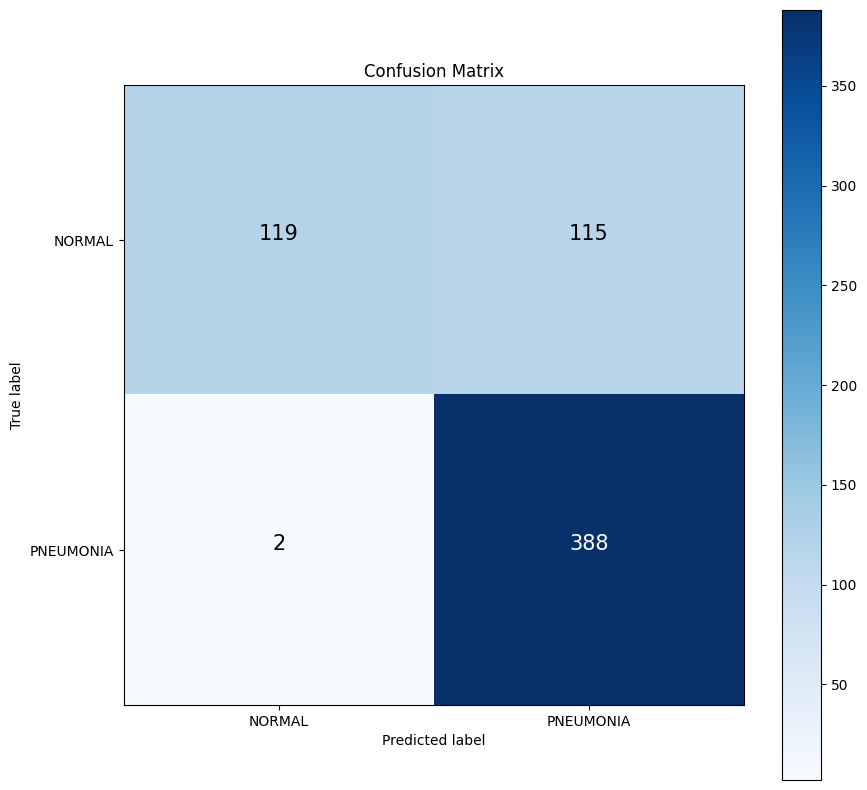

In [ ]:
# Default threshold of 0.5
evaluate_model(true_labels, predictions, test_data.class_names)

### `ROC Curves`

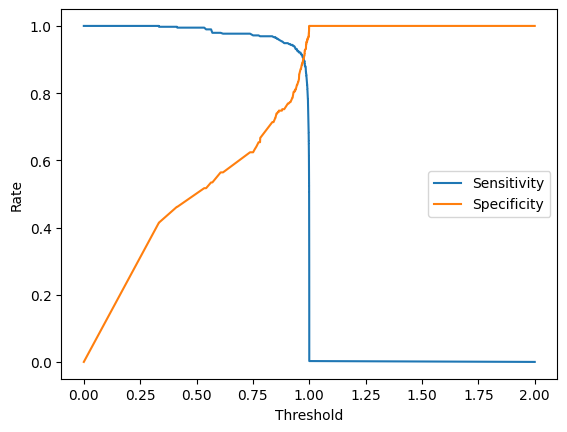

In [ ]:
plot_roc_curves(true_labels, predictions)

              precision    recall  f1-score   support

         0.0       0.92      0.73      0.81       234
         1.0       0.85      0.96      0.91       390

    accuracy                           0.88       624
   macro avg       0.89      0.85      0.86       624
weighted avg       0.88      0.88      0.87       624



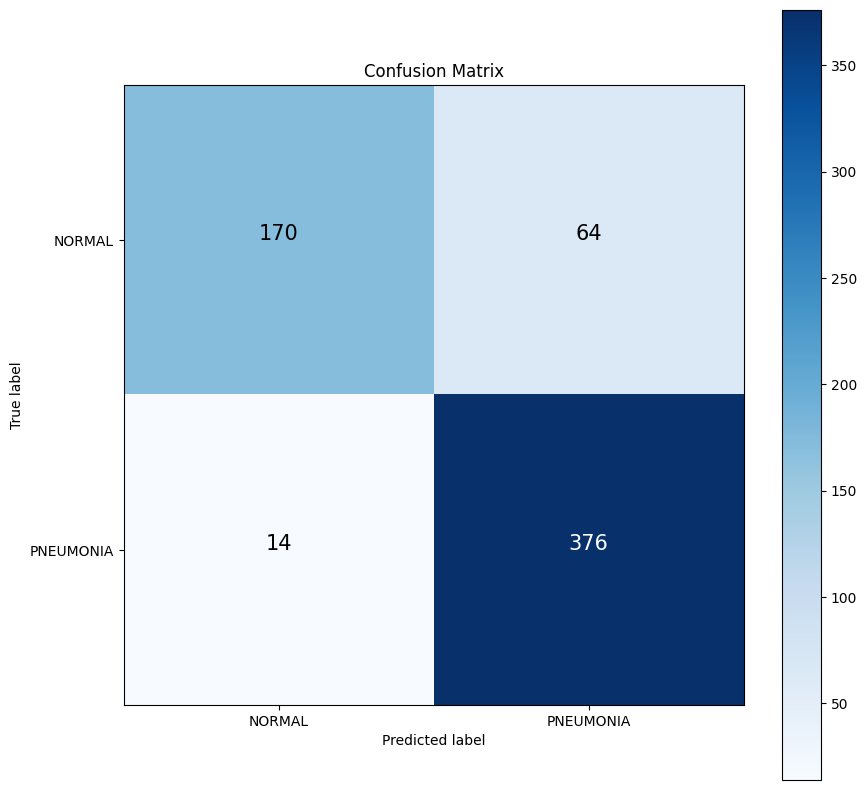

In [ ]:
evaluate_model(true_labels, predictions, test_data.class_names, threshold=0.85)

## `Conclusion`:
The sensitivity for both class seems to improve with `data augmenation`. This means we are making progress with the experiments.



# `Model 1.1 : DenseNet with Data Augmentation`

In [ ]:
dense_net_base_model = tf.keras.applications.densenet.DenseNet121(
    include_top=False
)
dense_net_base_model.trainable = False

inputs = layers.Input(shape=(224,224,3),name="input_layer")
x = data_augmentation(inputs)
x = dense_net_base_model(inputs, training=False)
x = layers.GlobalAveragePooling2D(name="global_average_pooling_layer")(x)
outputs = layers.Dense(1, activation = 'sigmoid', name='output_layer')(x)
model_1_1 = tf.keras.Model(inputs, outputs)

In [ ]:
# Compile 

model_1_1.compile(loss="binary_crossentropy",
              optimizer = tf.keras.optimizers.Adam(),
              metrics=["accuracy"])

# Fit
dense_net_base_model_history = model_1_1.fit(train_data,
                          epochs = 5,
                          validation_data = val_data,
                          callbacks=[create_tensorboard_callback("naami", "dense_net_data_aug")])

Saving TensorBoard log files to: naami/dense_net_data_aug/20230506-113950
Epoch 1/5
163/163 [==============================] - 44s 214ms/step - loss: 0.3156 - accuracy: 0.8585 - val_loss: 1.3245 - val_accuracy: 0.5625
Epoch 2/5
163/163 [==============================] - 35s 207ms/step - loss: 0.1793 - accuracy: 0.9300 - val_loss: 1.2210 - val_accuracy: 0.5625
Epoch 3/5
163/163 [==============================] - 34s 202ms/step - loss: 0.1493 - accuracy: 0.9461 - val_loss: 1.2680 - val_accuracy: 0.6250
Epoch 4/5
163/163 [==============================] - 34s 199ms/step - loss: 0.1258 - accuracy: 0.9567 - val_loss: 0.9156 - val_accuracy: 0.6250
Epoch 5/5
163/163 [==============================] - 36s 214ms/step - loss: 0.1139 - accuracy: 0.9630 - val_loss: 1.5440 - val_accuracy: 0.5625


In [ ]:
predictions = model_1_1.predict(test_data)

20/20 [==============================] - 6s 152ms/step


### `Classification Report`

              precision    recall  f1-score   support

         0.0       0.98      0.19      0.32       234
         1.0       0.67      1.00      0.80       390

    accuracy                           0.69       624
   macro avg       0.82      0.59      0.56       624
weighted avg       0.79      0.69      0.62       624



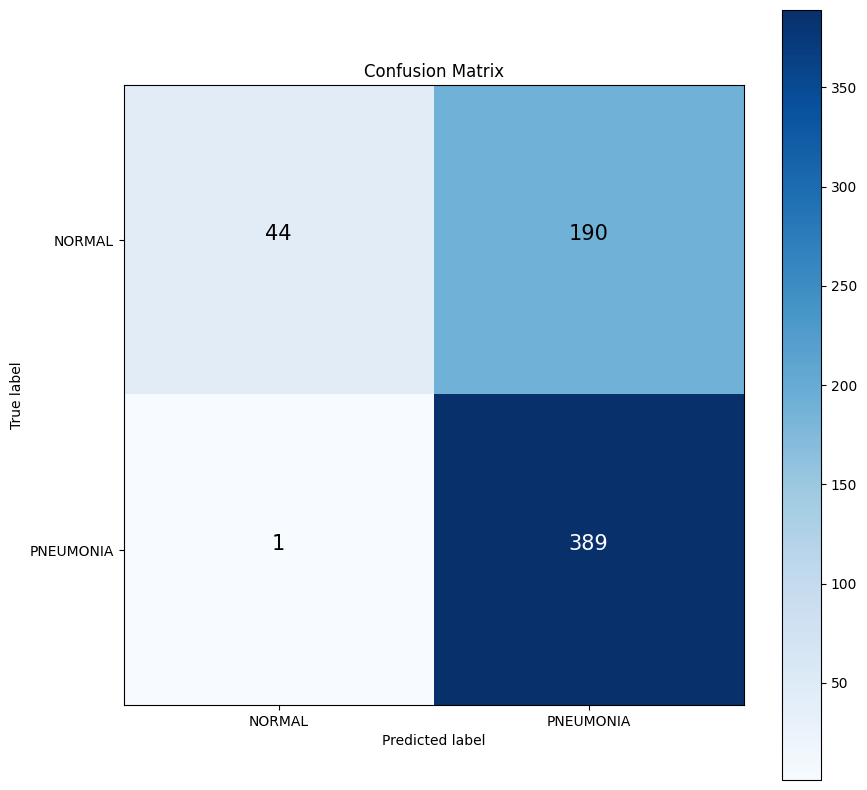

In [ ]:
evaluate_model(true_labels, predictions, test_data.class_names)

### Plot Loss Curves

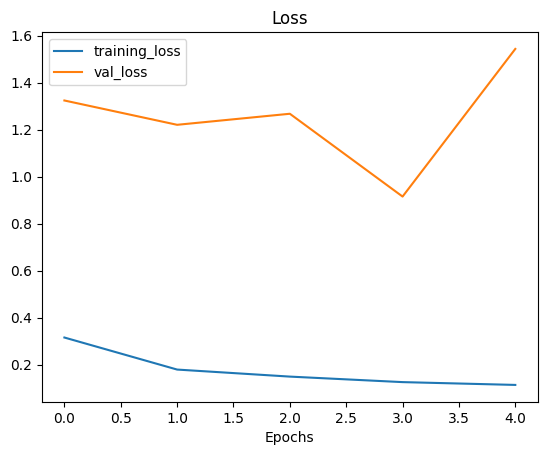

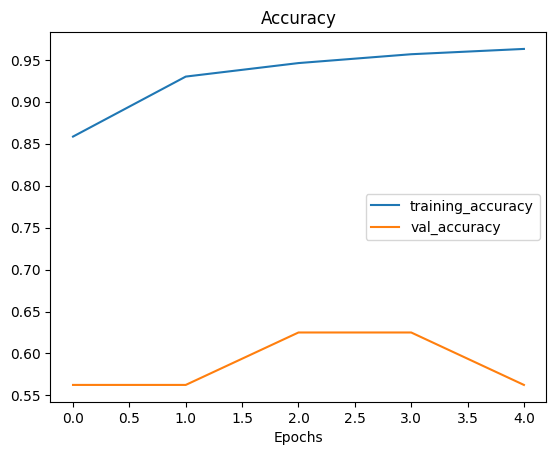

In [ ]:
plot_loss_curves(dense_net_base_model_history)

### `ROC curves`

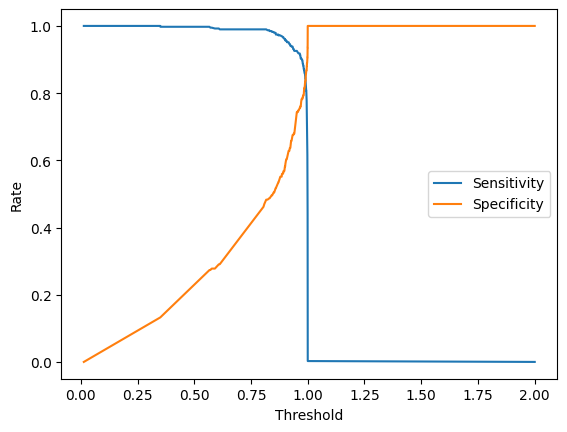

In [ ]:
plot_roc_curves(true_labels, predictions)

              precision    recall  f1-score   support

         0.0       0.94      0.50      0.66       234
         1.0       0.77      0.98      0.86       390

    accuracy                           0.80       624
   macro avg       0.85      0.74      0.76       624
weighted avg       0.83      0.80      0.78       624



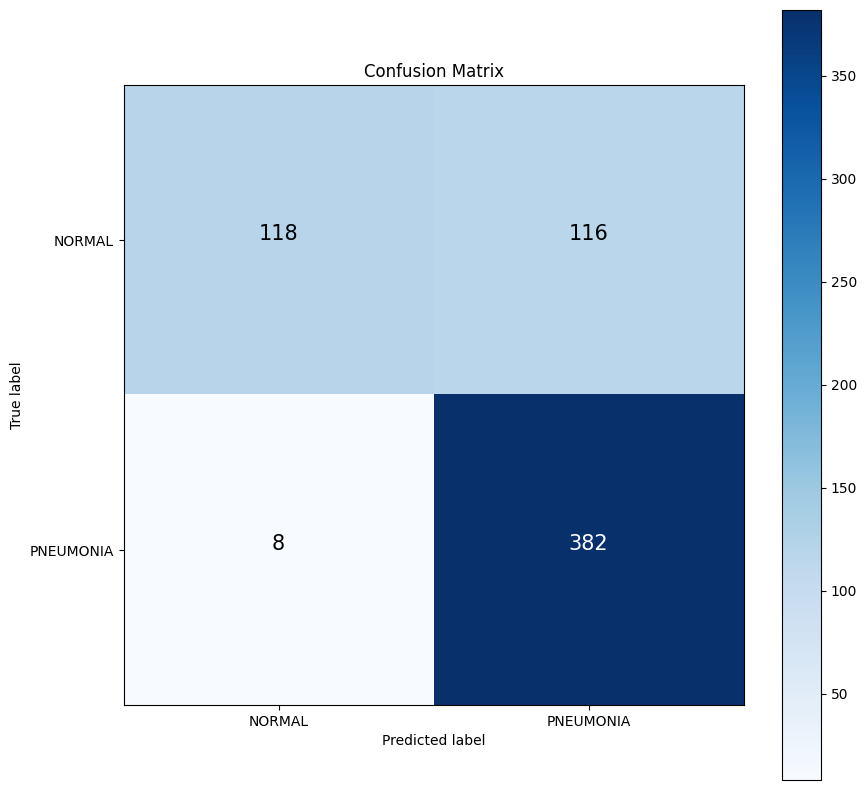

In [ ]:
evaluate_model(true_labels, predictions, test_data.class_names, threshold=0.85)

# `Phase II Conclusion`:
It seems that data augmentation had some effect on the performance of our both model.
* The `ResNet` model with data augmentation improved the performance on recall for both the classes.
*The `DenseNet` model with data augmentation improved the performance on recall for only majority classe.


# `Experimentation Phase III`:

Till now, the ResNet has upper hand over the DenseNet Model. In the upcoming section, I will be now performing transfer learning for fine tuning with decreasing learing rate by `10 times`.


# Model 0.2 : Fine-Tuning ResNet Model

In [ ]:
resnet_base_model = tf.keras.applications.resnet50.ResNet50(weights='imagenet',include_top=False)
resnet_base_model.trainable = False

inputs = layers.Input(shape=(224,224,3),name="input_layer")
x = layers.Rescaling(1./255)(inputs)
x = resnet_base_model(inputs, training=False)
x = layers.GlobalAveragePooling2D(name="global_average_pooling_layer")(x)
outputs = layers.Dense(1, activation = 'sigmoid', name='output_layer')(x)
model = tf.keras.Model(inputs, outputs)

In [ ]:
# Compile 
model.compile(loss="binary_crossentropy",
              optimizer = tf.keras.optimizers.Adam(),
              metrics=["accuracy"])

# Fit
resnet_base_model_history = model.fit(train_data,
                          epochs = 5,
                          validation_data = val_data,
                          )

Epoch 1/5
163/163 [==============================] - 38s 206ms/step - loss: 0.3613 - accuracy: 0.8482 - val_loss: 0.5263 - val_accuracy: 0.6875
Epoch 2/5
163/163 [==============================] - 34s 198ms/step - loss: 0.2093 - accuracy: 0.9319 - val_loss: 0.4831 - val_accuracy: 0.6875
Epoch 3/5
163/163 [==============================] - 34s 204ms/step - loss: 0.1672 - accuracy: 0.9421 - val_loss: 0.5169 - val_accuracy: 0.6875
Epoch 4/5
163/163 [==============================] - 36s 207ms/step - loss: 0.1458 - accuracy: 0.9484 - val_loss: 0.4531 - val_accuracy: 0.7500
Epoch 5/5
163/163 [==============================] - 34s 198ms/step - loss: 0.1314 - accuracy: 0.9536 - val_loss: 0.4359 - val_accuracy: 0.7500


## `Fine-tuning`

In [ ]:
resnet_base_model.trainable = True
for layer in resnet_base_model.layers[:-10]:
  layer.trainable = False


# Recompile the model
# Decreasing the learning rate by 10 times
model.compile(loss="binary_crossentropy",
                optimizer = tf.keras.optimizers.Adam(learning_rate=0.0001),
                metrics=["accuracy"] )

In [ ]:

# Fine tune for 5 more epochs
fine_tune_epochs = 10



history_model_fine_tuned = model.fit(train_data,
                                     epochs=fine_tune_epochs,
                                     validation_data=val_data,
                                     initial_epoch=resnet_base_model_history.epoch[-1],
                                     callbacks=[create_tensorboard_callback("naami", "resnet_model_fine_tuned")])

Saving TensorBoard log files to: naami/resnet_model_fine_tuned/20230506-114957
Epoch 5/10
163/163 [==============================] - 34s 196ms/step - loss: 0.1217 - accuracy: 0.9565 - val_loss: 0.4435 - val_accuracy: 0.7500
Epoch 6/10
163/163 [==============================] - 34s 198ms/step - loss: 0.1135 - accuracy: 0.9586 - val_loss: 0.4574 - val_accuracy: 0.7500
Epoch 7/10
163/163 [==============================] - 34s 202ms/step - loss: 0.1077 - accuracy: 0.9601 - val_loss: 0.4211 - val_accuracy: 0.7500
Epoch 8/10
163/163 [==============================] - 34s 196ms/step - loss: 0.1021 - accuracy: 0.9630 - val_loss: 0.4437 - val_accuracy: 0.7500
Epoch 9/10
163/163 [==============================] - 33s 193ms/step - loss: 0.0976 - accuracy: 0.9638 - val_loss: 0.4590 - val_accuracy: 0.7500
Epoch 10/10
163/163 [==============================] - 35s 206ms/step - loss: 0.0939 - accuracy: 0.9664 - val_loss: 0.4339 - val_accuracy: 0.7500


In [ ]:
model.evaluate(test_data)

20/20 [==============================] - 3s 133ms/step - loss: 0.4344 - accuracy: 0.8061


[0.4343611001968384, 0.8060897588729858]

## `Loss Curves`

In [ ]:
def compare_history(original_history, new_history, initial_epochs=5):
  acc = original_history.history["accuracy"]
  loss = original_history.history["loss"]

  val_acc = new_history.history["val_accuracy"]
  val_loss = new_history.history["val_loss"]

  # Combine original history
  total_acc = acc + new_history.history["accuracy"]
  total_loss = loss + new_history.history["loss"]

  # Combine val history
  total_val_acc = val_acc + new_history.history["val_accuracy"]
  total_val_loss = val_loss + new_history.history["val_loss"]

  plt.figure(figsize=(8,8))
  plt.subplot(2, 1, 1)
  plt.plot(total_acc, label="Training Accuracy")
  plt.plot(total_val_acc, label = "Val Accuracy")
  plt.plot([initial_epochs-1, initial_epochs-1], plt.ylim(), label="Start Fine Tuninig")
  plt.legend(loc="lower right")
  plt.title("Training and Validation Accuracy")

  plt.figure(figsize=(8,8))
  plt.subplot(2, 1, 2)
  plt.plot(total_loss ,label="Training Loss")
  plt.plot(total_val_loss, label = "Val Loss")
  plt.plot([initial_epochs-1, initial_epochs-1], plt.ylim(), label="Start Fine Tuninig")
  plt.legend(loc="upper right")
  plt.title("Training and Validation Loss")

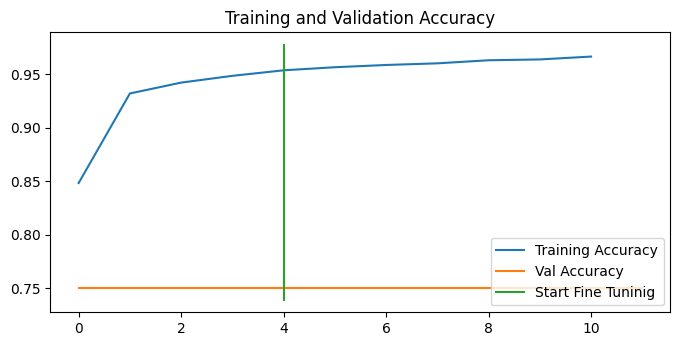

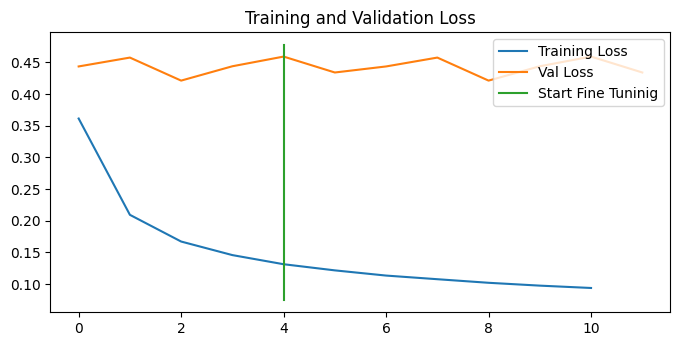

In [ ]:
compare_history(
    resnet_base_model_history,
    history_model_fine_tuned,
    5
) 

## `Classification Report`

In [ ]:
predictions = model.predict(test_data)

20/20 [==============================] - 8s 286ms/step


              precision    recall  f1-score   support

         0.0       0.94      0.51      0.66       234
         1.0       0.77      0.98      0.86       390

    accuracy                           0.81       624
   macro avg       0.86      0.75      0.76       624
weighted avg       0.84      0.81      0.79       624



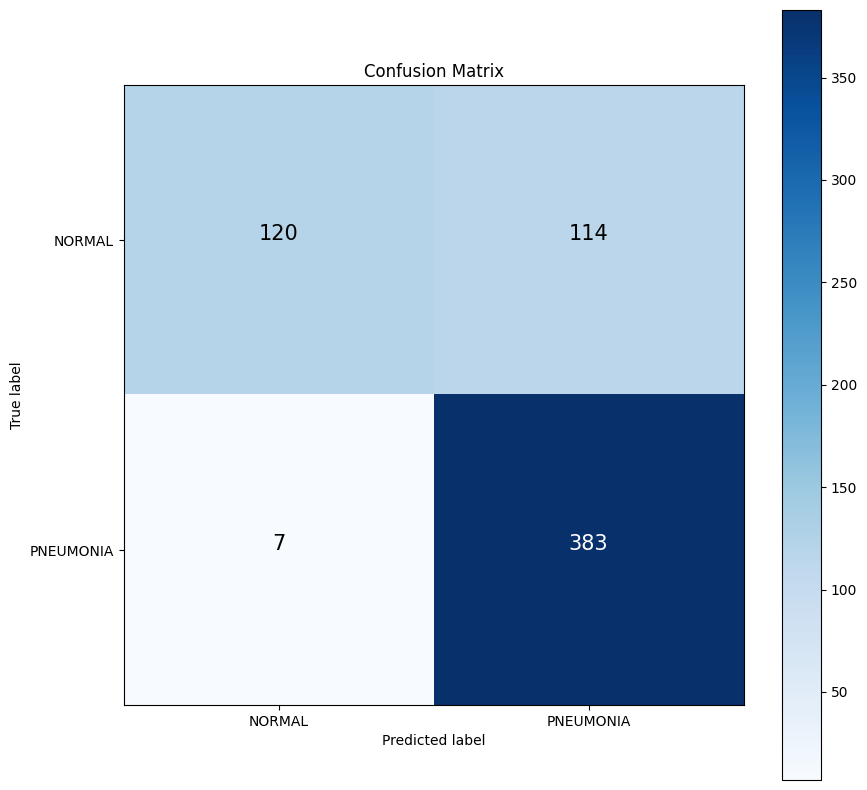

In [ ]:
evaluate_model(true_labels, predictions, test_data.class_names)

### ROC Curves

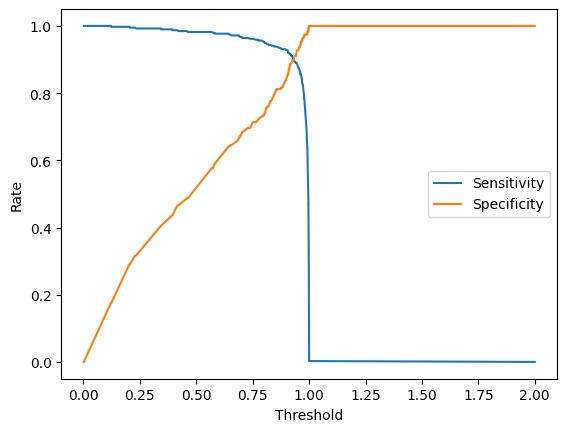

In [ ]:
plot_roc_curves(true_labels, predictions)

              precision    recall  f1-score   support

         0.0       0.89      0.80      0.84       234
         1.0       0.89      0.94      0.91       390

    accuracy                           0.89       624
   macro avg       0.89      0.87      0.88       624
weighted avg       0.89      0.89      0.89       624



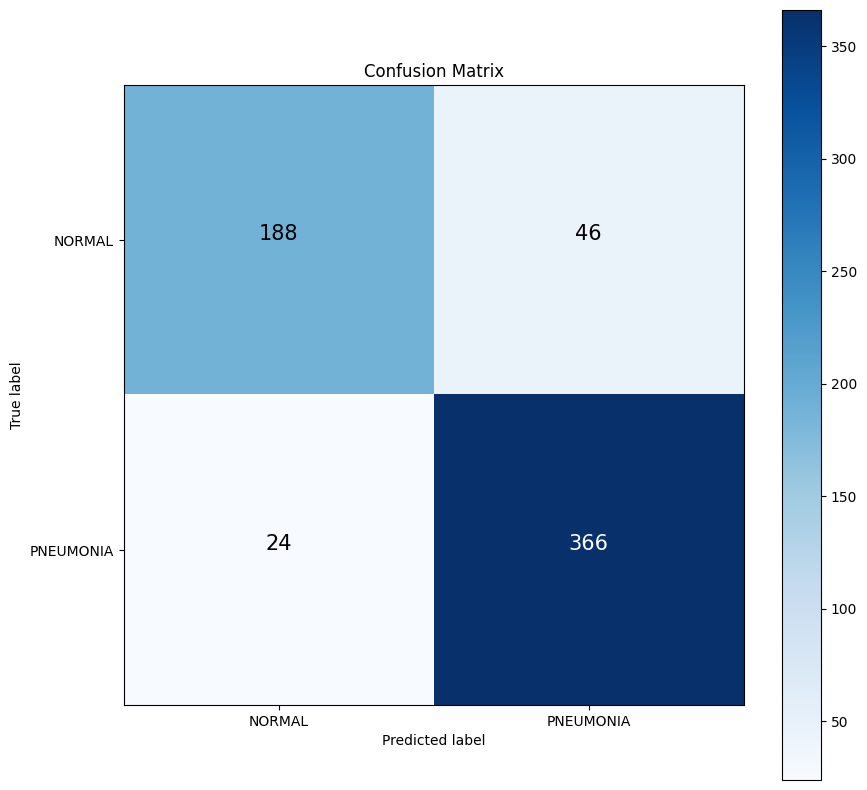

In [ ]:
evaluate_model(true_labels, predictions, test_data.class_names, threshold=0.85)

## `Conclusion`

The fine tuned model seems to perform better than all the models till now. Since the `sensitivity and specificity` seems to be well balanced.


# `Experimentation Phase IV:` 
In the upcoming section, I will be trying out data augmentation along with fine tuning the ResNet model.

# `Model 0.3: Fine-Tuning ResNet model with Data Augmentation` 

In [ ]:
resnet_base_model = tf.keras.applications.resnet50.ResNet50(weights='imagenet',include_top=False)
resnet_base_model.trainable = False

inputs = layers.Input(shape=(224,224,3),name="input_layer")
x = data_augmentation(inputs)
x = resnet_base_model(inputs, training=False)
x = layers.GlobalAveragePooling2D(name="global_average_pooling_layer")(x)
outputs = layers.Dense(1, activation = 'sigmoid', name='output_layer')(x)
model = tf.keras.Model(inputs, outputs)

In [ ]:
# Compile 
model.compile(loss="binary_crossentropy",
              optimizer = tf.keras.optimizers.Adam(learning_rate=0.0001),
              metrics=["accuracy"])

# Fit
resnet_base_model_history = model.fit(train_data,
                          epochs = 5,
                          validation_data = val_data,
                          )

Epoch 1/5
163/163 [==============================] - 40s 209ms/step - loss: 0.4822 - accuracy: 0.7619 - val_loss: 0.7126 - val_accuracy: 0.6250
Epoch 2/5
163/163 [==============================] - 33s 195ms/step - loss: 0.2533 - accuracy: 0.9166 - val_loss: 0.6673 - val_accuracy: 0.6250
Epoch 3/5
163/163 [==============================] - 35s 206ms/step - loss: 0.1909 - accuracy: 0.9392 - val_loss: 0.6553 - val_accuracy: 0.6250
Epoch 4/5
163/163 [==============================] - 33s 195ms/step - loss: 0.1617 - accuracy: 0.9471 - val_loss: 0.5979 - val_accuracy: 0.6250
Epoch 5/5
163/163 [==============================] - 35s 204ms/step - loss: 0.1435 - accuracy: 0.9526 - val_loss: 0.5970 - val_accuracy: 0.6250


In [ ]:
# Fine tune for 5 more epochs
fine_tune_epochs = 10

history_model_fine_tuned = model.fit(train_data,
                                     epochs=fine_tune_epochs,
                                     validation_data=val_data,
                                     initial_epoch=resnet_base_model_history.epoch[-1],
                                     callbacks=[create_tensorboard_callback("naami", "resnet_model_data_aug_fine_tuned")])

Saving TensorBoard log files to: naami/resnet_model_data_aug_fine_tuned/20230506-120026
Epoch 5/10
163/163 [==============================] - 34s 198ms/step - loss: 0.1313 - accuracy: 0.9553 - val_loss: 0.5979 - val_accuracy: 0.6250
Epoch 6/10
163/163 [==============================] - 34s 202ms/step - loss: 0.1221 - accuracy: 0.9567 - val_loss: 0.5315 - val_accuracy: 0.6875
Epoch 7/10
163/163 [==============================] - 34s 197ms/step - loss: 0.1142 - accuracy: 0.9592 - val_loss: 0.5348 - val_accuracy: 0.6875
Epoch 8/10
163/163 [==============================] - 33s 195ms/step - loss: 0.1082 - accuracy: 0.9615 - val_loss: 0.5025 - val_accuracy: 0.7500
Epoch 9/10
163/163 [==============================] - 35s 209ms/step - loss: 0.1028 - accuracy: 0.9636 - val_loss: 0.4860 - val_accuracy: 0.7500
Epoch 10/10
163/163 [==============================] - 33s 198ms/step - loss: 0.0986 - accuracy: 0.9649 - val_loss: 0.4955 - val_accuracy: 0.7500


In [ ]:
model.evaluate(test_data)

20/20 [==============================] - 4s 212ms/step - loss: 0.4530 - accuracy: 0.7997


[0.4530097246170044, 0.7996794581413269]

## `Classification Report`

In [ ]:
predictions = model.predict(test_data)

20/20 [==============================] - 7s 237ms/step


              precision    recall  f1-score   support

         0.0       0.95      0.49      0.65       234
         1.0       0.76      0.98      0.86       390

    accuracy                           0.80       624
   macro avg       0.86      0.74      0.75       624
weighted avg       0.83      0.80      0.78       624



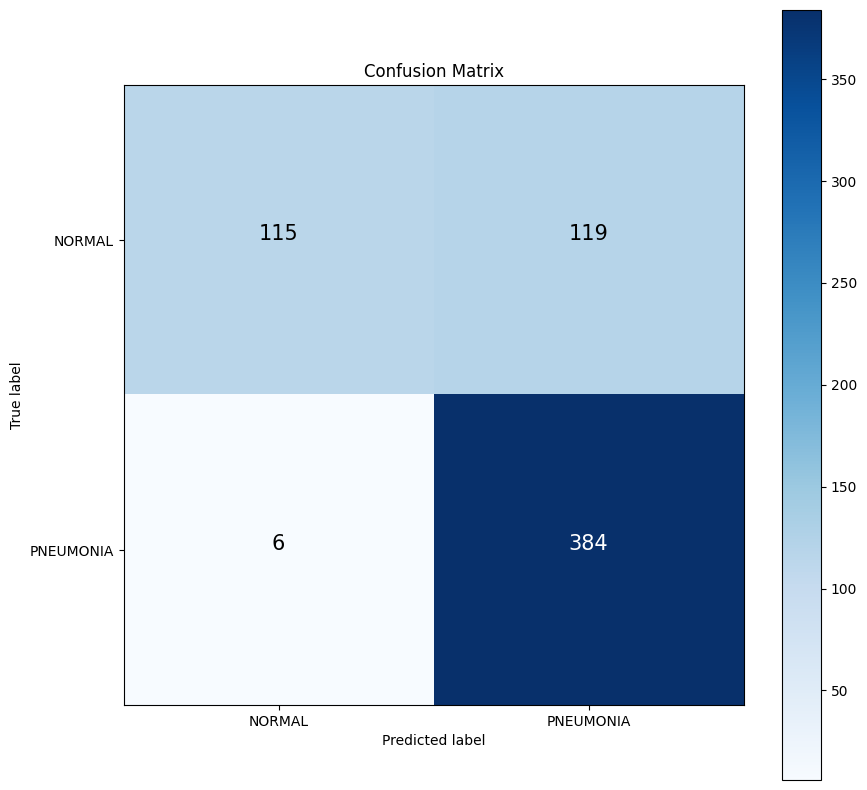

In [ ]:
evaluate_model(true_labels, predictions, test_data.class_names)

## `ROC Curves`

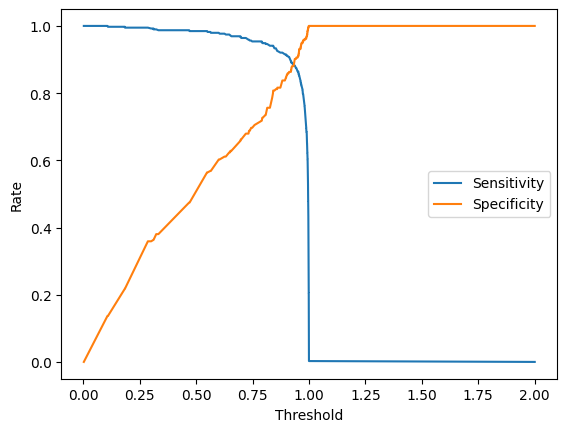

In [ ]:
plot_roc_curves(true_labels, predictions)

              precision    recall  f1-score   support

         0.0       0.88      0.81      0.84       234
         1.0       0.89      0.93      0.91       390

    accuracy                           0.89       624
   macro avg       0.89      0.87      0.88       624
weighted avg       0.89      0.89      0.89       624



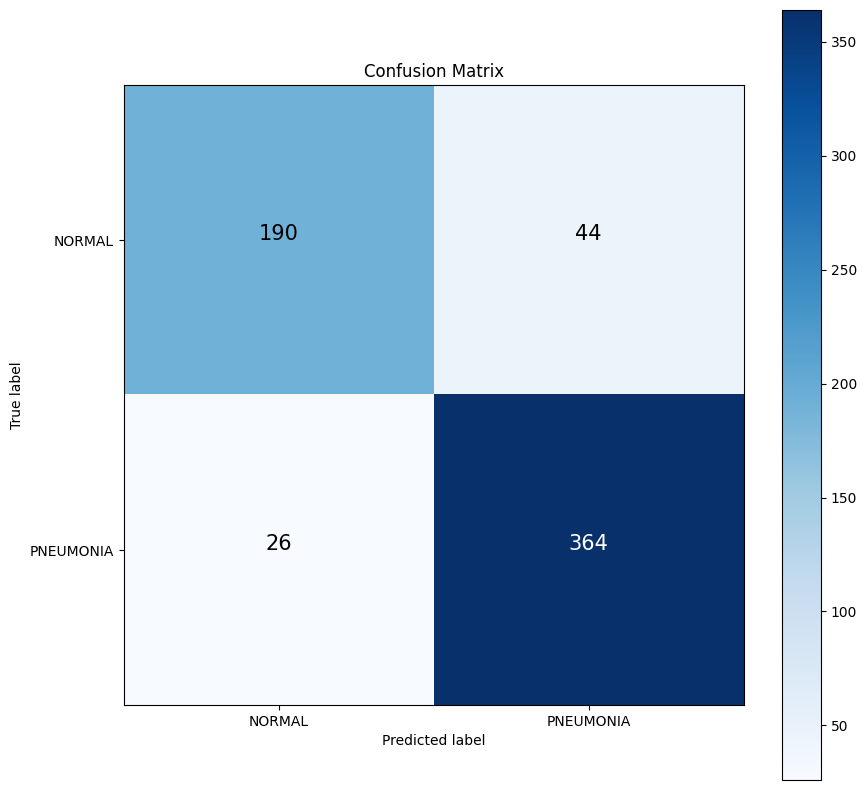

In [ ]:
evaluate_model(true_labels, predictions, test_data.class_names, threshold=0.85)

## `Conclusion`:

Here, we can conclude that fine-tuning the ResNet model and  data augmentation helped the performance of the model in terms of both `specificity` and `sensitivity.`

# `Visualizing the experiments on tensorboard`

In [ ]:
# !tensorboard dev upload --logdir ./naami \
# --name "Experimentation with Penumonia Datasets"\
# --description "A series of different transfer learning experiments with data augmentation and fine tuning."\
# --one_shot

# `Final Model`

After running a series of experiments, the model with high specificity and sensitivity was `DenseNet121` Architecture with sensitity of around `98%` and specificity of around `52%`. This model will now be used for further tasks like predictions and class activation map. The threshold for classfication will be now set to around `0.75` as per the `ROC curve`.

In [ ]:
final_model = model

# `Visualizing Predictions on Test Images`

In [ ]:
# Create a function to load and prepare images
def load_and_prep_image(filename, img_shape=224, scale=True):
  """
    Reads in an image from filename, turns it into a tensor and reshapes into 
    specified shape
  """
  # Read the image
  img = tf.io.read_file(filename)

  # Decode image into tensor
  img = tf.io.decode_image(img, channels=3)

  # Resize the image
  img = tf.image.resize(img, [img_shape, img_shape])

  if scale:
    return img/255.
  else:
    return img

1/1 [==============================] - 0s 27ms/step


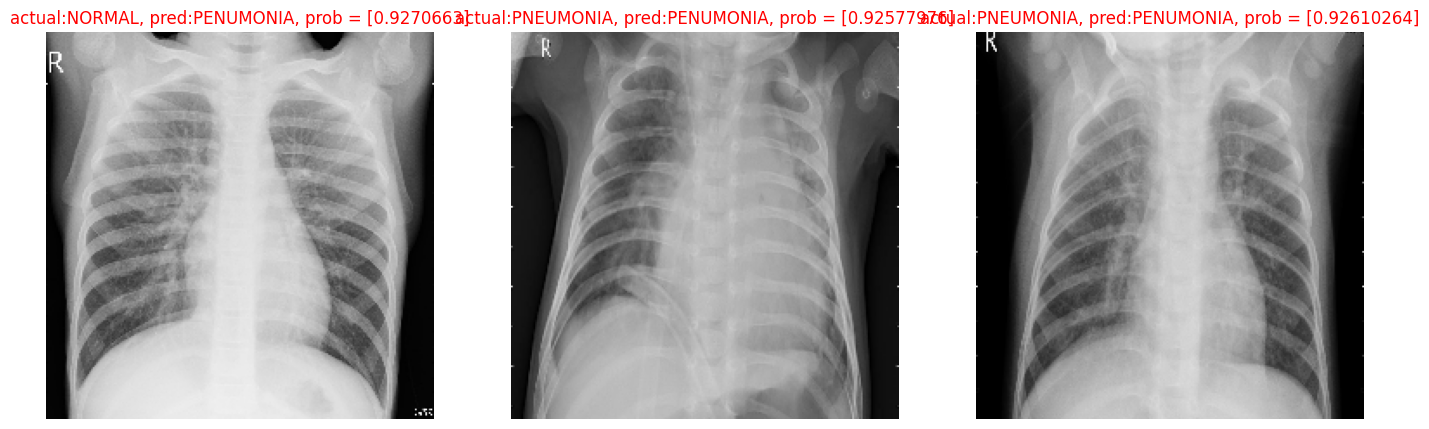

In [ ]:
import os
import random

plt.figure(figsize=(17,10))

for i in range(3):
  class_name = random.choice(test_data.class_names)
  filename = random.choice(os.listdir(TEST_DIR + "/" + class_name))
  filepath = TEST_DIR + "/" + class_name + "/" + filename

  img = load_and_prep_image(filepath)
  pred_prob = final_model.predict(tf.expand_dims(img,axis=0))
  if pred_prob < 0.85:
    pred_class = "NORMAL"
  else:
    pred_class = "PENUMONIA"
  
  plt.subplot(1, 3, i+1)
  plt.imshow(img)
  if class_name == pred_class:
    title_color = "g"
  else:
    title_color = "r"
  plt.title(f"actual:{class_name}, pred:{pred_class}, prob = {pred_prob[0]}", c=title_color)
  plt.axis(False);

# `Class Activation Map`

In [ ]:
!wget https://raw.githubusercontent.com/Bhandari007/Pnemonia_Classification/main/cam.py

--2023-05-06 12:14:08--  https://raw.githubusercontent.com/Bhandari007/Pnemonia_Classification/main/cam.py
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.108.133, 185.199.109.133, 185.199.110.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.108.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 1846 (1.8K) [text/plain]
Saving to: ‘cam.py’

cam.py              100%[===================>]   1.80K  --.-KB/s    in 0s      

2023-05-06 12:14:08 (26.8 MB/s) - ‘cam.py’ saved [1846/1846]



In [ ]:
from cam import GradCAM

In [ ]:
class_name = random.choice(test_data.class_names)
filename = random.choice(os.listdir(TEST_DIR + "/" + class_name))
filepath = TEST_DIR + "/" + class_name + "/" + filename
print(filepath)

chest_xray/test/PNEUMONIA/person1619_virus_2806.jpeg


In [ ]:
from tensorflow.keras.applications import ResNet50
from tensorflow.keras.preprocessing.image import img_to_array
from tensorflow.keras.preprocessing.image import load_img
from tensorflow.keras.applications import imagenet_utils
import numpy as np
import argparse
import imutils
import cv2

In [ ]:
model = ResNet50()

102967424/102967424 [==============================] - 1s 0us/step


In [ ]:
orig = cv2.imread(filepath)
resized = cv2.resize(orig, (224, 224))

image = load_img(filepath, target_size=(224,224))
image = img_to_array(image)
image =  np.expand_dims(image, axis=0)
print(image.shape)
image = imagenet_utils.preprocess_input(image)
print(image.shape)

(1, 224, 224, 3)
(1, 224, 224, 3)


In [ ]:
preds = model.predict(image)
i = np.argmax(preds[0])

decoded = imagenet_utils.decode_predictions(preds)
(imagenetID, label, prob) = decoded[0][0]
label = "{}: {:.2f}%".format(label, prob * 100)
print("[INFO] {}".format(label))

35363/35363 [==============================] - 0s 0us/step
[INFO] fountain: 99.50%


In [ ]:
import tensorflow as tf
import numpy as np
import cv2
from tensorflow.keras.models import Model

class GradCAM:
  def __init__(self, model, classIdx, layerName=None):
    self.model = model
    self.classIdx = classIdx
    self.layerName = layerName
    if self.layerName is None:
      self.layerName = self.find_target_layer()
    
  def find_target_layer(self):
    for layer in reversed(self.model.layers):
      if len(layer.output.shape) == 4:
        return layer.name
        
    raise ValueError("Could not find 4D layer. Cannot apply GradCAM.")
    

  def compute_heatmap(self, image, eps=1e-8):
    gradModel = Model(
          inputs = [self.model.inputs],
          outputs = [self.model.get_layer(self.layerName).output,
                     self.model.output]
      )

    with tf.GradientTape() as tape:
        inputs = tf.cast(image, tf.float32)

        (convOutputs, predictions) = gradModel(inputs)
        loss = predictions[:, self.classIdx]
      
    grads = tape.gradient(loss, convOutputs)

    
    castConvOutputs = tf.cast(convOutputs>0, "float32")
    castGrads = tf.cast(grads >0, "float32")
    guidedGrads = castConvOutputs * castGrads * grads

    convOutputs = convOutputs[0]
    guidedGrads = guidedGrads[0]

    weights = tf.reduce_mean(guidedGrads, axis=(0,1))
    cam = tf.reduce_sum(tf.multiply(weights, convOutputs), axis=-1)

    (w, h) = (image.shape[2], image.shape[1])

    heatmap = cv2.resize(cam.numpy(), (w, h))

    numer = heatmap - np.min(heatmap)
    denom = (heatmap.max() - heatmap.min()) + eps
    heatmap = numer / denom

    heatmap = (heatmap * 255).astype("uint8")

    return heatmap

    
  def overlay_heatmap(self, heatmap, image, alpha=0.5, colormap = cv2.COLORMAP_VIRIDIS):
    heatmap = cv2.applyColorMap(heatmap, colormap)
    output = cv2.addWeighted(image, alpha, heatmap, 1-alpha, 0)

    return (heatmap, output)

In [ ]:
cam = GradCAM(model, i)
heatmap = cam.compute_heatmap(image)

heatmap = cv2.resize(heatmap, (orig.shape[1], orig.shape[0]))
(heatmap, output) = cam.overlay_heatmap(heatmap, orig, alpha=0.5)

output = cv2.resize(output, (orig.shape[1], output.shape[0]))
print(output.shape)

(816, 1304, 3)


In [ ]:
from google.colab.patches import cv2_imshow

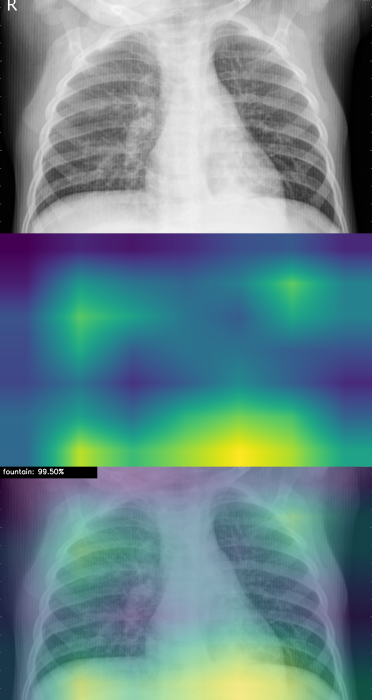

-1

In [ ]:
# draw the predicted label on the output image
cv2.rectangle(output, (0, 0), (340, 40), (0, 0, 0), -1)
cv2.putText(output, label, (10, 25), cv2.FONT_HERSHEY_SIMPLEX, 0.8, (255, 255, 255), 2)
# # display the original image and resulting heatmap and output image  to our screen
output = np.vstack([orig, heatmap, output])
output = imutils.resize(output, height=700)
cv2_imshow(output)
cv2.waitKey(0)

# `References`
>* https://journals.plos.org/plosone/article?id=10.1371/journal.pone.0256630
* https://www.tensorflow.org/api_docs
*https://pyimagesearch.com/2020/03/09/grad-cam-visualize-class-activation-maps-with-keras-tensorflow-and-deep-learning